<a href="https://colab.research.google.com/github/Johnnyyy24/Linear-Regression-in-Predicting-Gold-Prices/blob/main/Gold_linearmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Inspired By Ishan Shah and Rekhit Pachanekar

<br>
 
### 使用簡單線性迴歸，嘗試看看對於金價預測的表現
<br>

加入其他商品價格

candidates: ^GSPC(SPY), DX-Y.NYB(USDX), SI=F(Silver)

In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 5.3 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=e0eabe8282f925d6c0dfef307140a54b7c9c8f66f5ac92f865e45369698b9363
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# yahoo finance is used to fetch data
import yfinance as yf

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

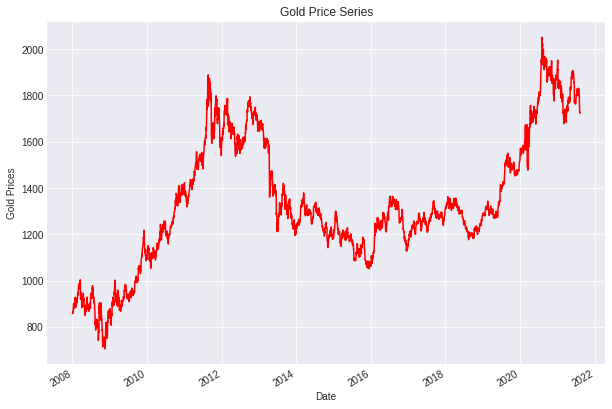

In [3]:
# Read data
gold = yf.download('GC=F', '2008-01-01', '2021-8-11', auto_adjust=True)
snp500 = yf.download('^GSPC','2008-01-01', '2021-8-11', auto_adjust=True) # 標普500
USDX = yf.download('DX-Y.NYB','2008-01-01', '2021-8-11', auto_adjust=True) # 美元指數
Silver = yf.download('SI=F','2008-01-01', '2021-8-11', auto_adjust=True) # 白銀

# Only keep close columns
Df = gold[['Close']]
Df['S&P'] = snp500['Close']
Df['USDX'] = USDX['Close']
Df['Silver'] = Silver['Close']
# Drop rows with missing values
Df = Df.dropna()

# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("Gold Prices")
plt.title("Gold Price Series")
plt.show()

In [4]:
# Define explanatory variables
Df['S_3'] = Df['Close'].rolling(window=3).mean()
Df['S_9'] = Df['Close'].rolling(window=9).mean()
Df['next_day_price'] = Df['Close'].shift(-1)

Df = Df.dropna()
X = Df[['S_3', 'S_9','S&P','USDX','Silver']]

# Define dependent variable
y = Df['next_day_price']

In [5]:
# Split the data into train and test dataset
t = .8
t = int(t*len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

In [6]:
# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f * S&P 500 Price (x3) \
+ %.2f * USDX index (x4) \
+ %.2f * Silver Price (x5) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1],  linear.coef_[2], linear.coef_[3], linear.coef_[4], linear.intercept_))

Linear Regression model
Gold Price (y) = 1.17 * 3 Days Moving Average (x1) + -0.19 * 9 Days Moving Average (x2) + 0.00 * S&P 500 Price (x3) + 0.15 * USDX index (x4) + 0.59 * Silver Price (x5) + -2.40 (constant)


S&P 的coef竟然為0 ？？再確認！

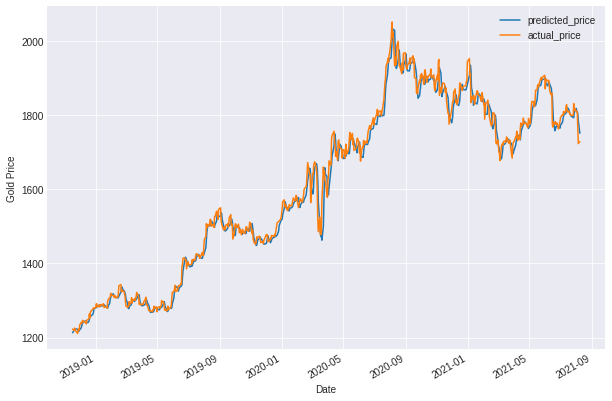

In [7]:
# Predicting the Gold prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['predicted_price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Price")
plt.show()

上面的圖縱軸比較寬，所以看起來才這麼準

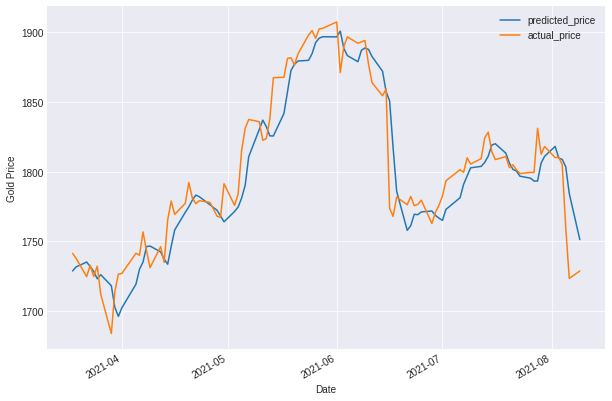

In [8]:
predicted_price[-100:].plot(figsize=(10, 7))
y_test[-100:].plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Price")
plt.show()

R score 表現如何

In [9]:
# R square
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

98.97

In [10]:
output_df = pd.merge(Df, predicted_price, left_index=True, right_index=True)
output_df

,Close,S&P,USDX,Silver,S_3,S_9,next_day_price,predicted_price
Date,,,,,,,,
2018-11-16,1220.800049,2736.270020,96.470001,14.358000,1213.833374,1213.477797,1223.099976,1213.357015
2018-11-19,1223.099976,2690.729980,96.190002,14.381000,1218.900024,1213.400011,1219.000000,1219.272212
2018-11-20,1219.000000,2641.889893,96.809998,14.247000,1220.966675,1212.600016,1225.800049,1221.845188
2018-11-21,1225.800049,2649.929932,96.709999,14.480000,1222.633341,1212.922241,1220.199951,1223.864051
2018-11-26,1220.199951,2673.449951,97.070000,14.183000,1221.666667,1214.455566,1211.199951,1222.323417
...,...,...,...,...,...,...,...,...
2021-08-03,1810.099976,4423.149902,92.080002,25.566000,1813.599976,1808.455539,1810.500000,1809.813695
2021-08-04,1810.500000,4402.660156,92.269997,25.445999,1812.899984,1809.066650,1805.099976,1808.826032
2021-08-05,1805.099976,4429.100098,92.239998,25.277000,1808.566650,1809.477756,1760.000000,1803.569132


In [11]:
def mse_loss(df):
    mse = .0
    y_true = df['predicted_price']
    y_pred = df['next_day_price']

    mse_series = (y_pred - y_true) ** 2
    mse = mse_series.sum() / len(mse_series)

    # print(mse_series)
    return mse

In [12]:
mse = mse_loss(output_df)
mse

532.0714919781095

### 策略測試：
預測明天收盤價在p, 若開盤價o<p 就進場買，無論如何都在當天收盤賣掉，並設置2:1的盈虧比

In [44]:
output_df = pd.merge(Df, predicted_price, left_index=True, right_index=True) 
output_df = pd.merge(output_df, gold['Open'], left_index=True, right_index=True) # 把開價加進來進行策略計算
output_df['predicted_price'] = output_df['predicted_price'].shift()
output_df['profit'] = 0

buy = output_df['predicted_price'] > output_df['Open']
sell = output_df['predicted_price'] < output_df['Open']

output_df['trade'] = 0 # 0 -> no trade

output_df.loc[buy,'trade'] = 1
output_df.loc[sell,'trade'] = -1

output_df.loc[buy,'profit'] = output_df['Close'] - output_df['Open']
output_df.loc[sell,'profit'] = output_df['Open'] - output_df['Close']

# 2:1 盈虧比
stop_earn = output_df['profit'] > 5
stop_loss = output_df['profit'] < -2.5
has_trade = output_df['trade'] != 0 

output_df.loc[has_trade & stop_earn,'profit'] = 5
output_df.loc[has_trade & stop_loss,'profit'] = -2.5

勝率

In [42]:
pos_profit = output_df['profit'] > 0 
len(output_df[pos_profit]) / len(output_df)

0.4844903988183161

In [ ]:
output_df

,Close,S&P,USDX,Silver,S_3,S_9,next_day_price,predicted_price,Open,profit,trade
Date,,,,,,,,,,,
2018-11-16,1220.800049,2736.270020,96.470001,14.358000,1213.833374,1213.477797,1223.099976,NaN,1216.699951,0.000000,0
2018-11-19,1223.099976,2690.729980,96.190002,14.381000,1218.900024,1213.400011,1219.000000,1213.357015,1223.099976,0.000000,-1
2018-11-20,1219.000000,2641.889893,96.809998,14.247000,1220.966675,1212.600016,1225.800049,1219.272212,1225.300049,5.000000,-1
2018-11-21,1225.800049,2649.929932,96.709999,14.480000,1222.633341,1212.922241,1220.199951,1221.845188,1225.800049,0.000000,-1
2018-11-26,1220.199951,2673.449951,97.070000,14.183000,1221.666667,1214.455566,1211.199951,1223.864051,1220.199951,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-03,1810.099976,4423.149902,92.080002,25.566000,1813.599976,1808.455539,1810.500000,1818.195394,1812.300049,-2.200073,1
2021-08-04,1810.500000,4402.660156,92.269997,25.445999,1812.899984,1809.066650,1805.099976,1809.813695,1809.300049,1.199951,1
2021-08-05,1805.099976,4429.100098,92.239998,25.277000,1808.566650,1809.477756,1760.000000,1808.826032,1810.800049,5.000000,-1


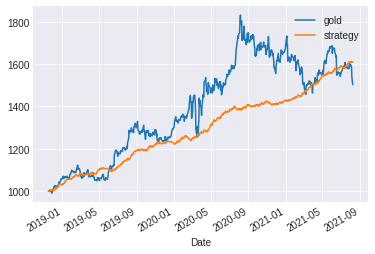

In [51]:
# 本金設定為 1,000
nav = output_df['profit'].cumsum() + 1000
(output_df['Close'] - output_df['Close'][0] + 1000).plot(label='gold')
nav.plot(label='strategy')

plt.legend()
plt.show()

最大回撤與夏普指數

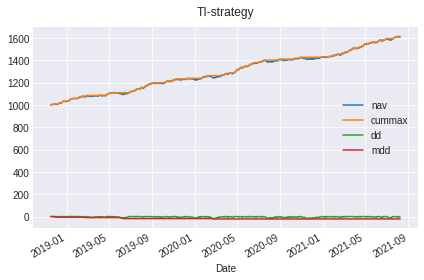

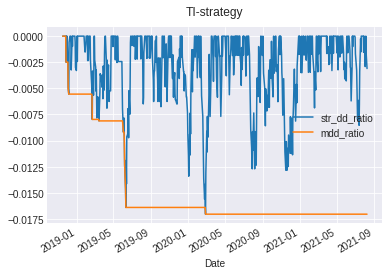

----------------------------------------
ti-strategy mdd= -0.01704590105929095


In [47]:
# 最大回撤
def get_mdd(nav): 
    mdd = 0.
    nav_max = nav.cummax() # 累積最大值
    drawdown = (nav - nav_max) / nav_max # 從上個波峰算每天的回撤比例
    mdd = drawdown.cummin() # drawdown是負值，取cummin找出最小的（絕對值最大）的回撤
    return mdd
    
daily_navs = nav
daily_navs.plot()
nav_max = daily_navs.cummax()
nav_max.plot()
dd = daily_navs-nav_max
dd.plot()
mdd = dd.cummin()
mdd.plot()
plt.title("TI-strategy", x=0.5, y=1.03)
plt.legend(['nav', 'cummax', 'dd', 'mdd'])

plt.tight_layout()
plt.show()

dd_ratio = dd/nav_max
dd_ratio.plot()
mdd_ratio = dd_ratio.cummin()
mdd_ratio.plot()
plt.legend(['str_dd_ratio', 'mdd_ratio'])
plt.title("TI-strategy", x=0.5, y=1.03)
plt.show()
print('-'*40)
print('ti-strategy mdd=', min(mdd_ratio))

In [49]:
# 計算 Sharpe Ratio
daily_return = (nav - nav.shift()) / nav.shift()
daily_return
sharpe_ratio = (daily_return.mean()/daily_return.std()) * 252 ** 0.5 
print('sharpe ratio=', sharpe_ratio)

sharpe ratio= 4.530962575402908


熱圖

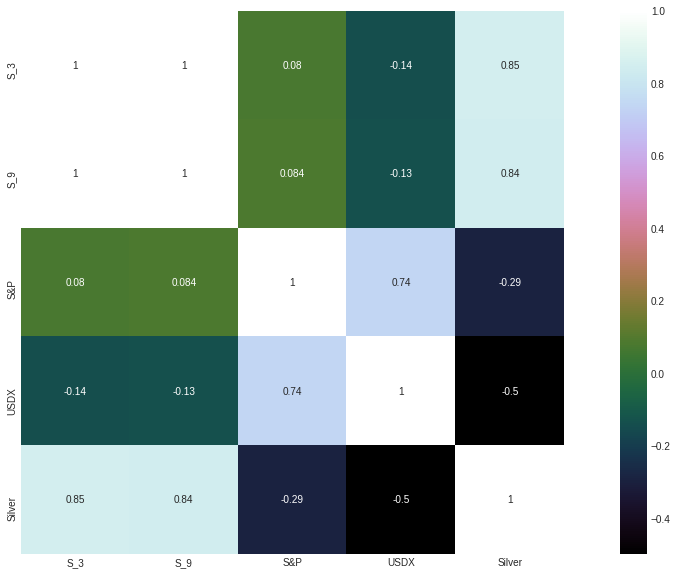

In [48]:
import seaborn as sns 
corr_mat=X_train.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')